In [1]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
show_animation=True


%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation

## Define global Map

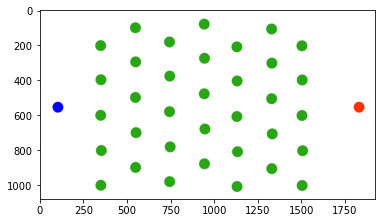

In [2]:
globalMap = cv2.imread( "./upload_dir/b3898d0e-ea1c-434b-b9b5-f354cead4217.jpg" )
plt.imshow( globalMap )

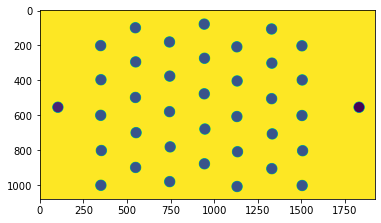

In [3]:
gray = cv2.cvtColor( globalMap, cv2.COLOR_BGR2GRAY )
plt.imshow(gray)

In [4]:
# detect circles
gray_blured = cv2.blur( gray, (3, 3) )

In [5]:
# get coordinate of the points
obstacles = []
index     = 0
import numpy as np
detected_circles = cv2.HoughCircles( gray_blured, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=1, maxRadius=40 )
if detected_circles is not None:
    detected_circles = np.uint16( np.around( detected_circles ) )
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        pos = (a, b)
        
        # border outline
        cv2.circle( globalMap, center=(a, b), radius=r, color=( 0, 0, 0 ), thickness=1 )
        obstacles.append( {
            "x" : a,
            "y" : b,
            "r" : r
        } )
        
        # create labels
        cv2.putText(globalMap, text=str(index), org=(a,b),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
        
        index+=1

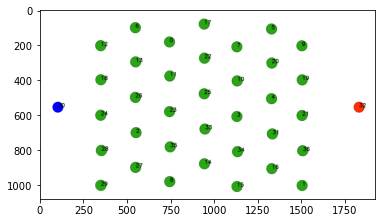

In [6]:
# show cirlces tracking
plt.imshow( globalMap )

In [7]:
df = pd.DataFrame( obstacles )
df.head(5)

# x, y coordinates and r = radius

,x,y,r
0,742,182,31
1,1502,1002,31
2,550,700,31
3,1128,608,31
4,1326,506,31


In [8]:
def get_coordinate( index ):
    # get coordinate given the index
    try:
        return obstacles[ index ]
    except IndexError:
        return {}

In [9]:
start = get_coordinate(0)
end   = get_coordinate(36)
print(start, end)

{'x': 742, 'y': 182, 'r': 31} {'x': 1506, 'y': 804, 'r': 31}


In [10]:
# create goals for start and end 
def create_goal():
    pass

In [11]:
# create obstacle
def create_obstacle():
    pass

In [12]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [13]:
KP = 5.0 # attractive protectial gain
RP = 100.0 # repulsive potential gain
AREA_WIDTH = 30.0 # potential area width 

# number of previous positional that is needed to check the occillation
OSCILLATIONS_DETECTION_LENGTH = 3

In [14]:
# calculate the potential field
def calc_potential_field(gx, gy, ox, oy, reso, rr, sx, sy):
    minx = min(min(ox), sx, gx) - AREA_WIDTH / 2.0
    miny = min(min(oy), sy, gy) - AREA_WIDTH / 2.0
    maxx = max(max(ox), sx, gx) + AREA_WIDTH / 2.0
    maxy = max(max(oy), sy, gy) + AREA_WIDTH / 2.0
    xw = int(round((maxx - minx) / reso))
    yw = int(round((maxy - miny) / reso))

    # calc each potential
    pmap = [[0.0 for i in range(yw)] for i in range(xw)]

    for ix in range(xw):
        x = ix * reso + minx

        for iy in range(yw):
            y = iy * reso + miny
            ug = calc_attractive_potential(x, y, gx, gy)
            uo = calc_repulsive_potential(x, y, ox, oy, rr)
            uf = ug + uo
            pmap[ix][iy] = uf

    return pmap, minx, miny

In [15]:
# calculate the attractive potential
def calc_attractive_potential(x, y, gx, gy):
    return 0.5 * KP * np.hypot(x - gx, y - gy)

In [16]:
# calculate the repulsive potential
def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 0.1:
            dq = 0.1

        return 0.5 * RP * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0

In [17]:
# ocillation detection
def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False

In [18]:
# motion model
def get_motion_model():
    # dx, dy
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion

In [19]:
# potential field planning
def potential_field_planning(sx, sy, gx, gy, ox, oy, reso, rr):

    # calc potential field
    pmap, minx, miny = calc_potential_field(gx, gy, ox, oy, reso, rr, sx, sy)

    # search path
    d = np.hypot(sx - gx, sy - gy)
    ix = round((sx - minx) / reso)
    iy = round((sy - miny) / reso)
    gix = round((gx - minx) / reso)
    giy = round((gy - miny) / reso)

    if show_animation:
        draw_heatmap(pmap)
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(ix, iy, "*k")
        plt.plot(gix, giy, "*m")

    rx, ry = [sx], [sy]
    motion = get_motion_model()
    previous_ids = deque()

    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if inx >= len(pmap) or iny >= len(pmap[0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[inx][iny]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + minx
        yp = iy * reso + miny
        d = np.hypot(gx - xp, gy - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break

        if show_animation:
            plt.plot(ix, iy, ".r")
            plt.pause(0.01)

    print("Goal!!")

    return rx, ry

In [20]:
# draw heatmaps
def draw_heatmap(data):
    data = np.array(data).T
    plt.pcolor(data, vmax=100.0, cmap=plt.cm.Blues)

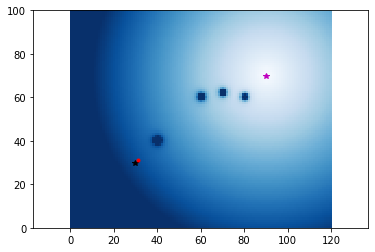

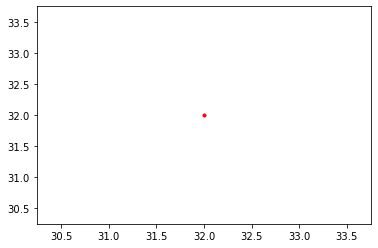

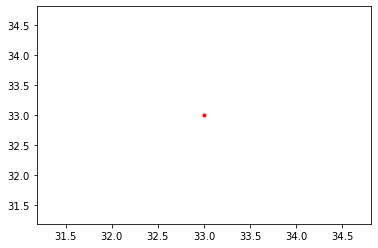

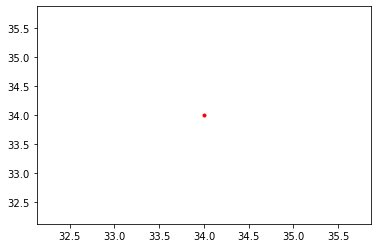

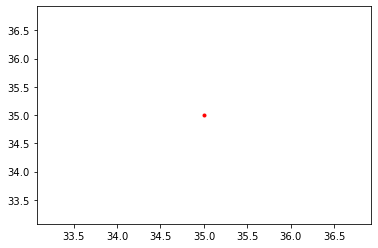

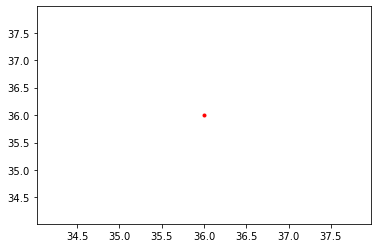

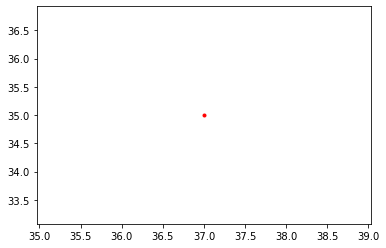

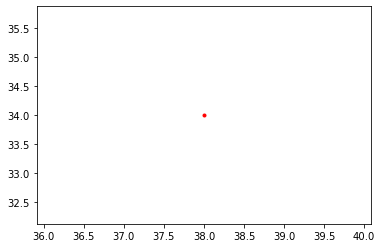

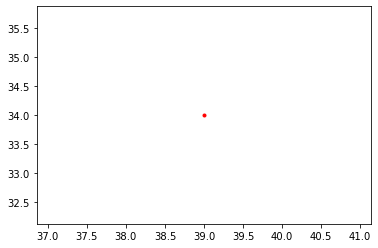

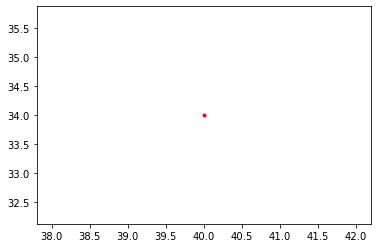

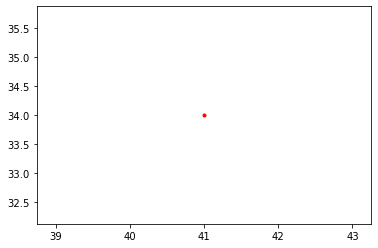

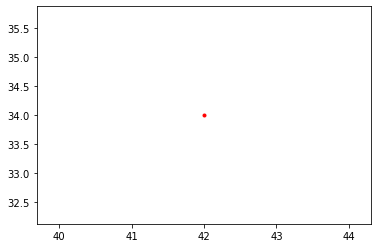

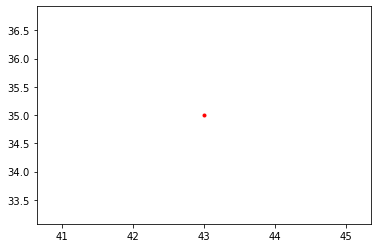

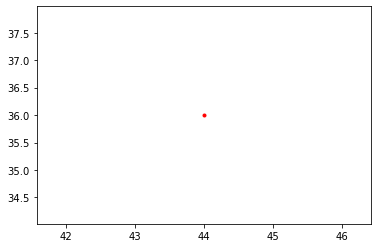

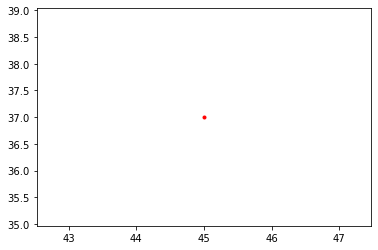

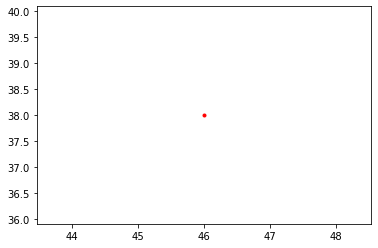

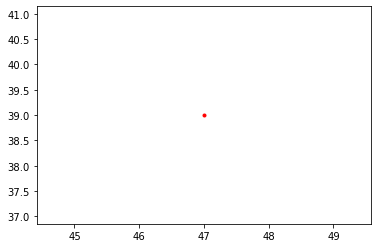

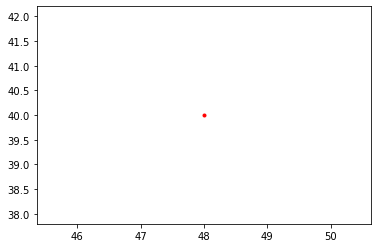

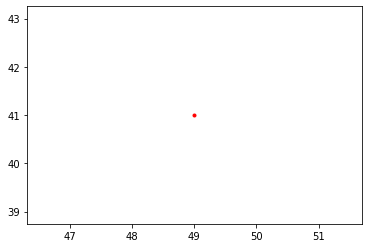

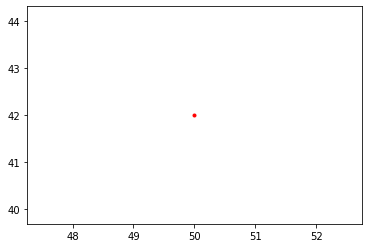

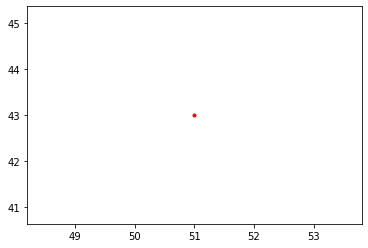

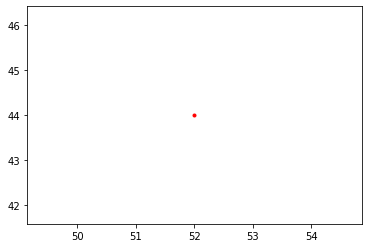

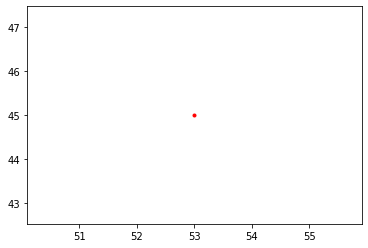

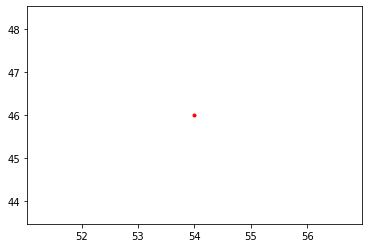

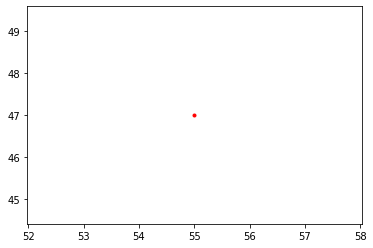

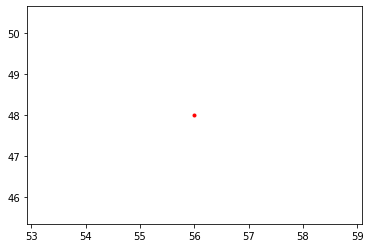

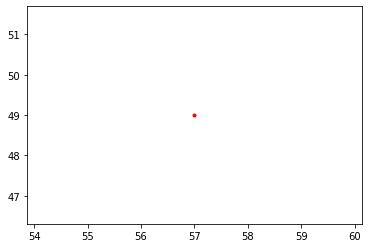

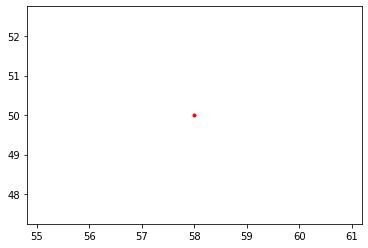

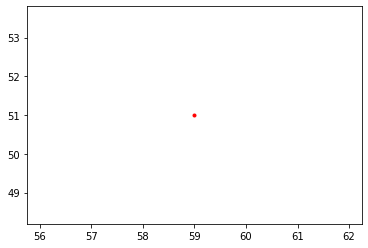

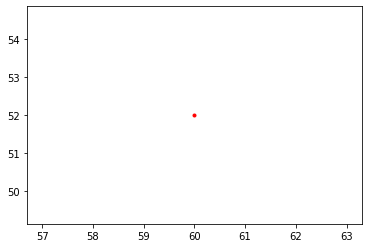

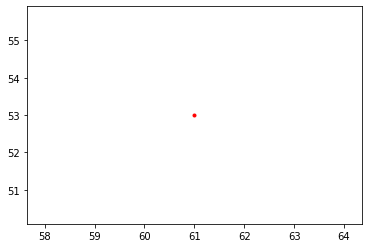

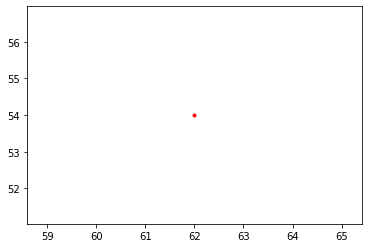

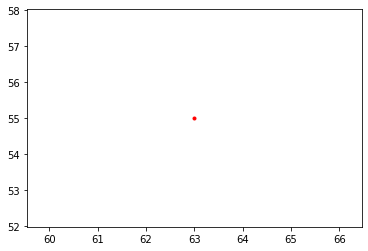

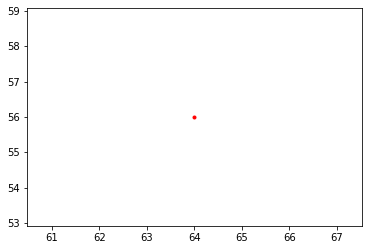

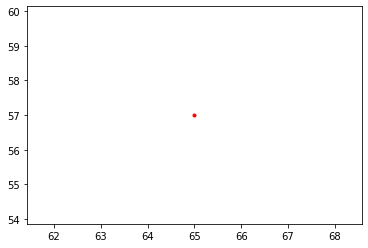

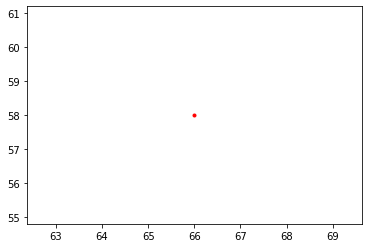

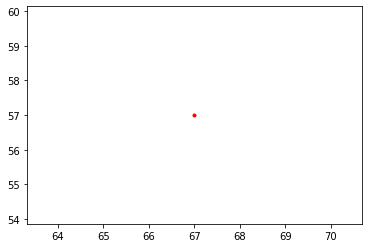

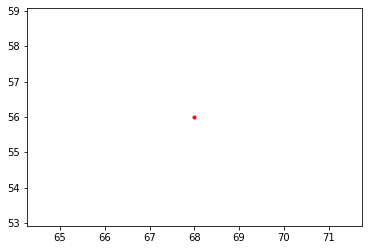

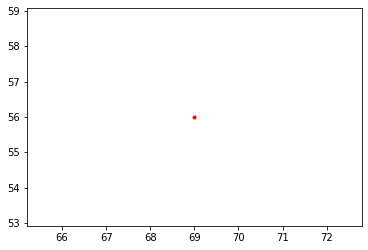

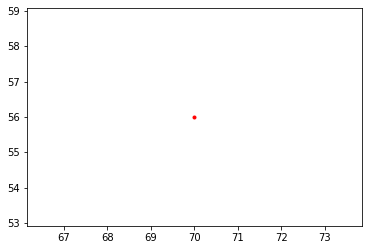

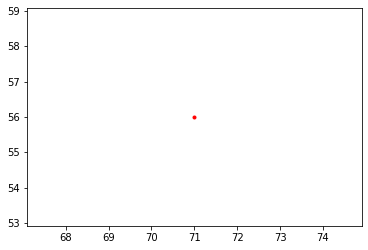

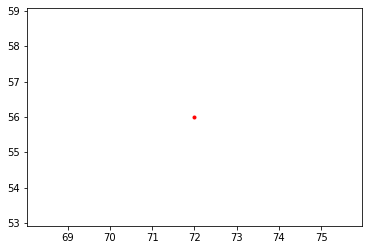

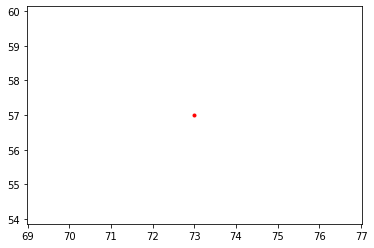

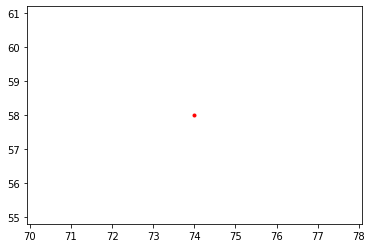

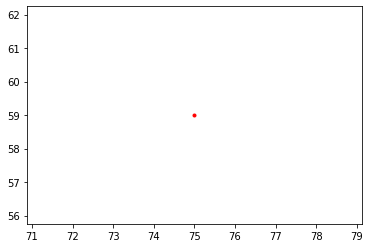

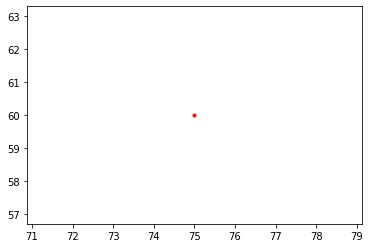

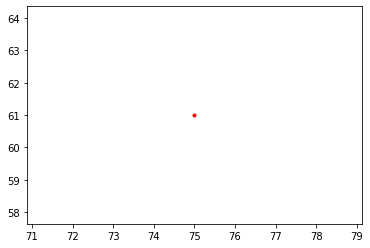

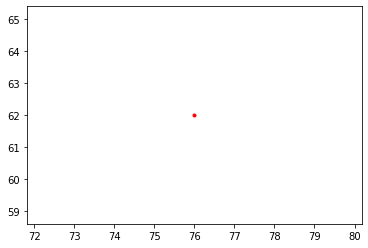

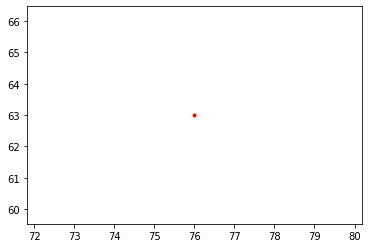

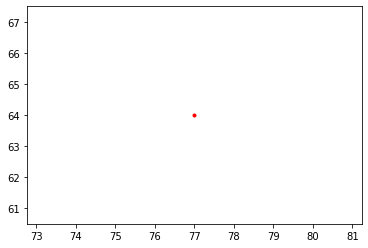

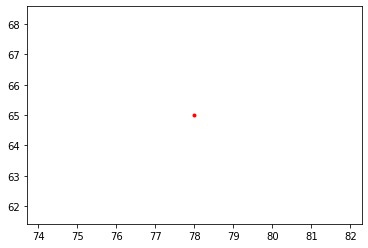

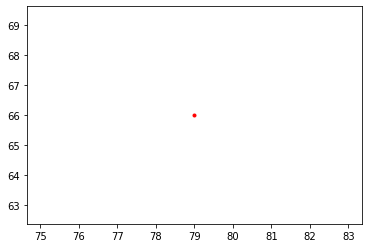

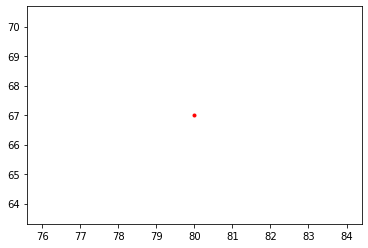

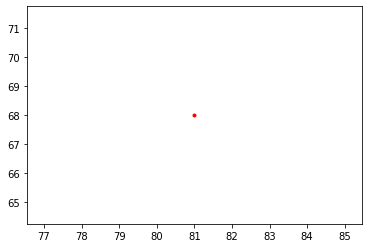

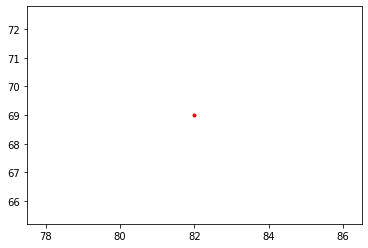

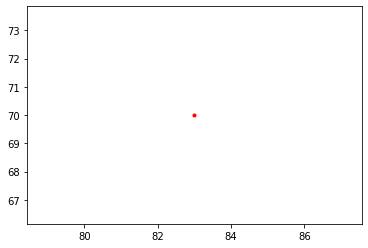

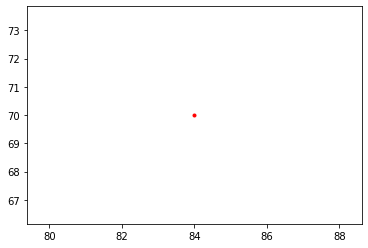

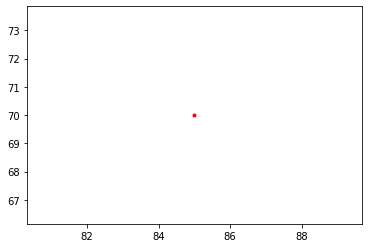

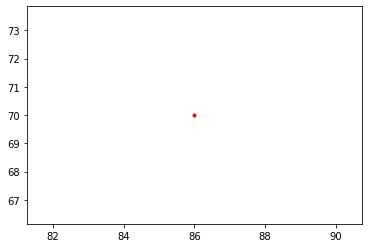

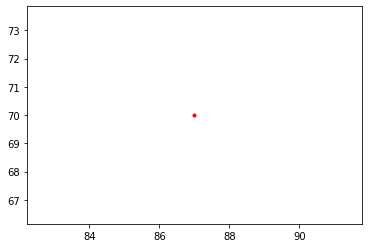

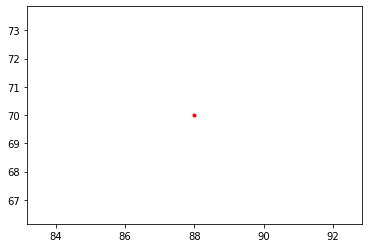

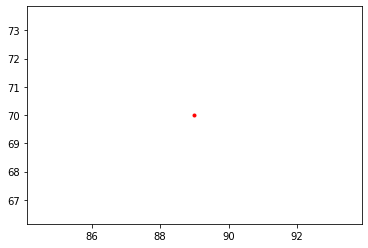

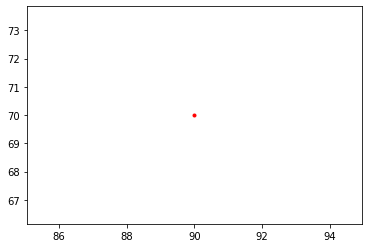

Goal!!


In [21]:
# starting position
sx = 0.0
sy = 10.0

# goal position
gx = 30.0
gy = 30.0

grid_size = 0.5
robot_size= 5.0 # robots secure radius size

ox = [ 15.0, 5.0, 20.0, 25.0 ]  # obstacle x positions
oy = [ 25.0, 15.0, 26.0, 25.0 ] # obstacle y positions

if show_animation:
    plt.grid(True)
    plt.axis("equal")

# path generation
_, _ = potential_field_planning(
    sx, sy, gx, gy, ox, oy, grid_size, robot_size
)
    
if show_animation:
    plt.show()

# def animate(frame_num):
#     return potential_field_planning( sx, sy, gx, gy, ox, oy, grid_size, robot_size )

# fig, ax = plt.subplots()
# t = np.linspace(0, 2 * np.pi )
# ani = matplotlib.animation.FuncAnimation( fig, animate, frames=100 )